# AirBnB Case
by David Keller



### Load required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

import folium
import folium.plugins

#import text2emotion as te
#import textblob
#from tqdm import tqdm
from dateutil.relativedelta import relativedelta
%matplotlib inline

tqdm.pandas()

NameError: name 'tqdm' is not defined

### Load airbnb Data

In [4]:
calendar = pd.read_csv('./data/airbnb_zurich/calendar.csv')
listings = pd.read_csv('./data/airbnb_zurich/listings.csv')
reviews = pd.read_csv('./data/airbnb_zurich/reviews.csv')

### Understand the Business of AirBnB

* Where are the best locations in Zürich? -> find a model to describe location to review_scores_location
* How can you optimize your return on AirBnB as a host?
* 

### Understand Data

In [5]:
listings.shape

(1860, 74)

In [6]:
calendar.shape

(678535, 7)

In [7]:
reviews.shape

(50245, 6)

In [8]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,https://www.airbnb.com/rooms/73282,20211228000812,2021-12-28,"Clean, central, quiet",Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,https://www.airbnb.com/rooms/86645,20211228000812,2021-12-28,Stadium Letzigrund - by Airhome,Discover a boutique apartment presented by Air...,Located 300 meters to Zurich Letzigrund Stadio...,https://a0.muscache.com/pictures/miso/Hosting-...,475053,https://www.airbnb.com/users/show/475053,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,https://www.airbnb.com/rooms/143821,20211228000812,2021-12-28,marvelous LOFT in SIHLCITY Zürich,<b>The space</b><br />- 2.5 rooms on 2 floors ...,NaN,https://a0.muscache.com/pictures/1012249/a4f34...,697307,https://www.airbnb.com/users/show/697307,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,https://www.airbnb.com/rooms/178448,20211228000812,2021-12-28,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,https://www.airbnb.com/rooms/204586,20211228000812,2021-12-28,very nice luxury city apartment,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


In [9]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful..."
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...


In [10]:
reviews.describe()

,listing_id,id,reviewer_id
count,5.024500e+04,5.024500e+04,5.024500e+04
mean,1.908273e+07,6.993185e+16,1.042475e+08
std,1.358630e+07,1.651534e+17,1.041389e+08
min,7.328200e+04,3.066130e+05,3.369000e+03
25%,6.293591e+06,2.333291e+08,2.288966e+07
50%,1.790682e+07,4.563381e+08,6.555674e+07
75%,2.750104e+07,6.503771e+08,1.582684e+08
max,5.380350e+07,5.266430e+17,4.366466e+08


### Work on Calendar Dataset

Convert price and adjusted_price column from string to float.

In [11]:
calendar.price = calendar.price.str.replace( "[$,]", "" ).astype(float)
calendar.adjusted_price = calendar.adjusted_price.str.replace( "[$,]", "" ).astype(float)

Convert available column to bool

In [12]:
# check the values in available column
calendar.available.unique()

array(['f', 't'], dtype=object)

In [13]:
calendar["available_boolean"] = (calendar.available == "t")
calendar.drop( "available", axis=1, inplace=True )

AirBnB has a mechanism to adjust prices dynamically. How does this mechanism work in our dataset? Check if price and adjusted_price have any difference:

In [14]:
calendar["price_difference"] = (calendar.price - calendar.adjusted_price)

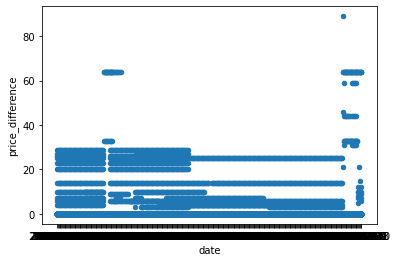

In [15]:
calendar[calendar.available_boolean].plot.scatter( x="date", y="price_difference" )

### Work on the Listings Dataset

In [12]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,https://www.airbnb.com/rooms/73282,20211228000812,2021-12-28,"Clean, central, quiet",Arty neighborhood<br /><br /><b>The space</b><...,NaN,https://a0.muscache.com/pictures/481072/abd94c...,377532,https://www.airbnb.com/users/show/377532,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,https://www.airbnb.com/rooms/86645,20211228000812,2021-12-28,Stadium Letzigrund - by Airhome,Discover a boutique apartment presented by Air...,Located 300 meters to Zurich Letzigrund Stadio...,https://a0.muscache.com/pictures/miso/Hosting-...,475053,https://www.airbnb.com/users/show/475053,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,https://www.airbnb.com/rooms/143821,20211228000812,2021-12-28,marvelous LOFT in SIHLCITY Zürich,<b>The space</b><br />- 2.5 rooms on 2 floors ...,NaN,https://a0.muscache.com/pictures/1012249/a4f34...,697307,https://www.airbnb.com/users/show/697307,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,https://www.airbnb.com/rooms/178448,20211228000812,2021-12-28,"a lovely place, top location","Very central location, 5 min walk from Bahnhof...","We live in one of the top locations of Zürich,...",https://a0.muscache.com/pictures/7d41e016-e818...,854016,https://www.airbnb.com/users/show/854016,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,https://www.airbnb.com/rooms/204586,20211228000812,2021-12-28,very nice luxury city apartment,<b>The space</b><br />share a room in a very n...,NaN,https://a0.muscache.com/pictures/55486203/9834...,1004816,https://www.airbnb.com/users/show/1004816,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN


Convert last_scraped to date. And extract the latest date in this column.

In [13]:
listings.last_scraped = pd.to_datetime( listings.last_scraped )
last_scraped_date = listings.last_scraped.max()
print("Last scraped date: %s" % last_scraped_date )

Last scraped date: 2021-12-28 00:00:00


In [14]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Drop columns not relevant for our questions.

In [15]:
listings.drop( ["listing_url", "scrape_id", "last_scraped", "name", "description", "neighborhood_overview", "picture_url", "host_id", "host_url"], axis=1 )

,id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,73282,Simona,2011-02-04,"Zurich, Zurich, Switzerland",I am from Italy and have lived in Zurich for a...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/377532/profil...,...,4.93,4.71,4.61,NaN,f,1,1,0,0,0.42
1,86645,James,2011-03-31,Wherever you need me. Always happy to help.,Backed by an international team of guest suppo...,within an hour,98%,94%,t,https://a0.muscache.com/im/users/475053/profil...,...,4.77,4.60,4.47,NaN,t,18,18,0,0,0.39
2,143821,Erhan,2011-06-13,"Zürich, Zurich, Switzerland",Hello everyone!\n\ni am living in Zurich.\n\nh...,within a day,100%,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,NaN,NaN,NaN,NaN,f,1,1,0,0,NaN
3,178448,Delphine,2011-07-22,"Zurich, Zurich, Switzerland","I am a quiet, friendly and caring person\r\nI ...",NaN,NaN,0%,f,https://a0.muscache.com/im/users/854016/profil...,...,4.89,5.00,4.89,NaN,f,1,0,1,0,0.07
4,204586,Aicha,2011-08-22,"Zurich, Zurich, Switzerland","I'm a very active person, love traveling, cook...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,53987227,Carena,2016-05-30,"Zürich, Zurich, Switzerland",NaN,within a few hours,100%,67%,f,https://a0.muscache.com/im/pictures/user/9ceeb...,...,NaN,NaN,NaN,NaN,f,2,2,0,0,NaN
1856,53998419,Mia,2018-06-26,"Zürich, Zurich, Switzerland",A happy person that occasionally opens her hom...,within an hour,100%,77%,f,https://a0.muscache.com/im/pictures/user/ee075...,...,NaN,NaN,NaN,NaN,t,8,8,0,0,NaN
1857,54009704,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,NaN,NaN,NaN,NaN,t,7,7,0,0,NaN
1858,54012299,Blueground,2021-12-01,"Zürich, Zurich, Switzerland",Why take a chance picking & choosing between s...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/882cb...,...,NaN,NaN,NaN,NaN,t,7,7,0,0,NaN


### Work on Reviews Dataset

Convert date-column to date-time.

In [16]:
reviews.date = pd.to_datetime( reviews.date )

How many unique reviewers do we have? Percentage of total number of reviews

In [17]:
len(reviews.reviewer_id.unique())/reviews.shape[0]

0.9079908448601851

In [36]:
reviews.groupby( reviews.reviewer_id ).head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful..."
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...
...,...,...,...,...,...,...
50240,53691391,524467838383695057,2021-12-24,4879473,Noel,Wonderful little flat with fantastic views and...
50241,53698682,517237336404489957,2021-12-14,214745755,Karim,perfect
50242,53698682,525191468654428690,2021-12-25,164767134,Jane,"Moro was a wonderful host, the most helpful ev..."
50243,53730106,515756983003727009,2021-12-12,396744268,Julien,Sehr sympathische & gut erschlossene Wohnung. ...


#### Extract Sentiments from Comments

In [27]:
sent = np.vectorize( textblob.TextBlob, reviews.comments.values )

ValueError: format number 1 of "Simona was an excellent hostess. The apartment is beautiful (and exactly like it is portrayed in the pictures). Simona made sure the apartment was well stocked with laundry detergent, toilet paper and even brought us a map to help us get around Zurich!  At one point the internet went out, and Simona was very responsive in helping us to solve the issue and get back online right away.  <br/><br/>The apartment is clean, bright, airy and very central to trams, busses, shops and the lake. <br/><br/>We would LOVE to stay here again when we return to Zurich in the future. " is not recognized

In [26]:
sent.sentiment

Sentiment(polarity=0.3546703296703297, subjectivity=0.5018925518925518)

In [26]:
pd.DataFrame( sent_pip( reviews.comments.to_list() ) )

Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


InvalidArgumentError: Exception encountered when calling layer "embeddings" (type TFEmbeddings).

indices[0,560] = 560 is not in [0, 512) [Op:ResourceGather]

Call arguments received:
  • input_ids=tf.Tensor(shape=(1, 565), dtype=int32)
  • position_ids=None
  • inputs_embeds=None
  • training=False

In [27]:
sent_pip?

### Join Datasets

In [58]:
reviews.join( listings, "", "inner" )

### Question: Best scoring locations

In [25]:
df_loc = listings[["latitude", "longitude", "review_scores_location"]]

Check if we have longitude and latitude for every listing.

In [26]:
df_loc.longitude.isnull().sum() == 0 and df_loc.latitude.isnull().sum() == 0

True

What percentage of location scores is NaN?

In [27]:
df_loc.review_scores_location.isnull().sum()/df_loc.shape[0]

0.20913978494623656

Roughly one fifth of rows are without a score for the location. We could either drop these before processing or inject a mean value. We follow the second approach here. If a guest does not review the location, we assume he has a neutral opinion here without ups or downs.

In [28]:
df_loc_filled = df_loc.fillna( value=df_loc.review_scores_location.mean(), axis=0 )

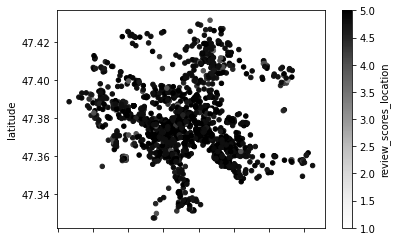

In [29]:
df_loc_filled.plot.scatter( x="longitude", y="latitude", c="review_scores_location" )

In [50]:
m = folium.Map(location = [df_loc_filled.latitude.mean(), df_loc_filled.longitude.mean()], tiles='Stamen toner', zoom_start = 12.)
folium.plugins.HeatMap( 
    df_loc_filled, name="Review Score Location", radius=10.,blur=10. ).add_to( m )
m

### Playground

In [14]:
te.get_emotion( reviews.comments.iat[0] )

{'Happy': 0.26, 'Angry': 0.11, 'Surprise': 0.21, 'Sad': 0.11, 'Fear': 0.32}

In [15]:
for i in range(10) :
        print( te.get_emotion( reviews.comments.iat[i] ))

{'Happy': 0.26, 'Angry': 0.11, 'Surprise': 0.21, 'Sad': 0.11, 'Fear': 0.32}
{'Happy': 0.62, 'Angry': 0.0, 'Surprise': 0.12, 'Sad': 0.12, 'Fear': 0.12}
{'Happy': 0.33, 'Angry': 0.17, 'Surprise': 0.0, 'Sad': 0.33, 'Fear': 0.17}
{'Happy': 0.29, 'Angry': 0.14, 'Surprise': 0.14, 'Sad': 0.43, 'Fear': 0.0}
{'Happy': 0.36, 'Angry': 0.14, 'Surprise': 0.07, 'Sad': 0.14, 'Fear': 0.29}
{'Happy': 0.33, 'Angry': 0.0, 'Surprise': 0.33, 'Sad': 0.17, 'Fear': 0.17}
{'Happy': 0.4, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.2, 'Fear': 0.4}
{'Happy': 0.0, 'Angry': 0.0, 'Surprise': 0.0, 'Sad': 0.0, 'Fear': 1.0}
{'Happy': 0.5, 'Angry': 0.0, 'Surprise': 0.17, 'Sad': 0.0, 'Fear': 0.33}
{'Happy': 0.25, 'Angry': 0.12, 'Surprise': 0.0, 'Sad': 0.12, 'Fear': 0.5}


In [14]:
reviews.Happy = np.nan
reviews.Angry = np.nan
reviews.Surprise = np.nan
reviews.Sad = np.nan
reviews.Fear = np.nan

In [54]:
reviews.comments.head(20).progress_apply( compute_emotions )

100%|██████████| 20/20 [00:03<00:00,  5.84it/s]


,Happy,Angry,Surprise,Sad,Fear
0,0.26,0.11,0.21,0.11,0.32
1,0.62,0.00,0.12,0.12,0.12
2,0.33,0.17,0.00,0.33,0.17
3,0.29,0.14,0.14,0.43,0.00
4,0.36,0.14,0.07,0.14,0.29
5,0.33,0.00,0.33,0.17,0.17
6,0.40,0.00,0.00,0.20,0.40
7,0.00,0.00,0.00,0.00,1.00
8,0.50,0.00,0.17,0.00,0.33
9,0.25,0.12,0.00,0.12,0.50
